# L2 FWI Example
We will solve this problem using the following steps:
1. Read the true and starting models from binary files, coarsen, and visualize
2. Build up a small local compute cluster and load required packages 
3. Build F, the nonlinear distributed block operator for seismic modeling
4. Use F and the true model to create a synthetic data-set
5. Build the gradient and cost functions
6. Perform the FWI using optim.jl

## Add required packages
Uncomment the line below if you need to add these packages to your environment

In [1]:
# ]add Optim LineSearches

In [2]:
using PyPlot, Distributed

## 1. Read true and starting models from binary files

In [3]:
v = read!("../20_marmousi_model_setup/marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176,851));
vₒ= read!("../20_marmousi_model_setup/marmousi_vp_smooth_20m_176x851.bin", Array{Float32}(undef, 176,851));

#### Subsample models
We will resample from the 20m grid to a 40m grid

In [4]:
v = v[1:3:end,1:3:end]
vₒ = vₒ[1:3:end,1:3:end];

In [5]:
dz,dx = 60.0,60.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (60.0, 60.0)
(nz, nx) = (59, 284)


#### Visualize

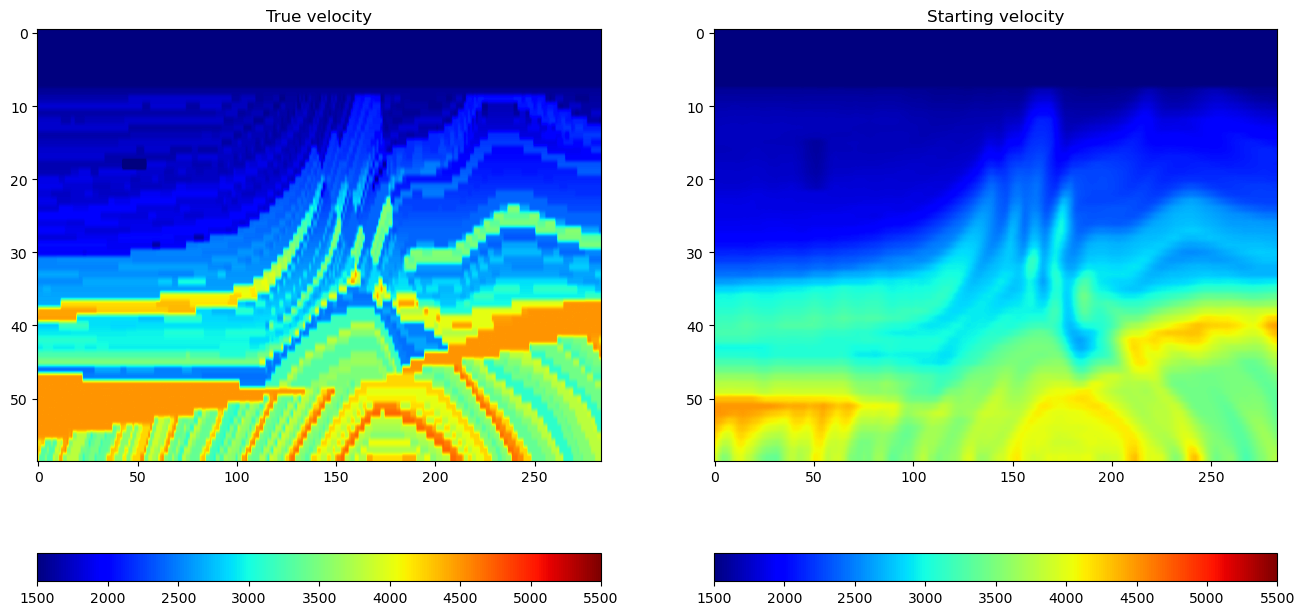

In [6]:
figure(figsize=(16,8))
subplot(121); imshow(v,aspect="auto",cmap="jet"); 
colorbar(orientation="horizontal"); clim(1500,5500); title("True velocity")
subplot(122); imshow(vₒ,aspect="auto",cmap="jet");
colorbar(orientation="horizontal"); clim(1500,5500); title("Starting velocity");

## 2. Build up a small local compute cluster and load required packages 

#### Setup OMP environment variables for the cluster
Note we need to do this because we are using 2 workers on the same physical node, and without setting up thread affinity the modeling will be *incredibly* slow.

In [7]:
nthread = Sys.CPU_THREADS
ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))" 
addprocs(2)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, nthread
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

# ENV["OMP_DYNAMIC"] = "true"
# ENV["OMP_STACKSIZE"] = "64M"
# ENV["OMP_WAIT_POLICY"] = "active"
# ENV["OMP_DISPLAY_AFFINITY"] = "true"
# ENV["GOMP_CPU_AFFINITY"] = "0-$(nthread)"

workers() = [2, 3]
(place1, place2, nthread) = (0, 21, 44)
(place1, place2, nthread) = (22, 43, 44)


In [8]:
@everywhere using Distributed, DistributedArrays, DistributedJets, Jets, JetPack, WaveFD, JetPackWaveFD, LinearAlgebra, LineSearches, Optim, Random


OPENMP DISPLAY ENVIRONMENT BEGIN
  _OPENMP = '201511'
  OMP_DYNAMIC = 'FALSE'
  OMP_NESTED = 'FALSE'
  OMP_NUM_THREADS = '22'
  OMP_SCHEDULE = 'DYNAMIC'
  OMP_PROC_BIND = 'CLOSE'
  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21},{22},{23},{24},{25},{26},{27},{28},{29},{30},{31},{32},{33},{34},{35},{36},{37},{38},{39},{40},{41},{42},{43}'
  OMP_STACKSIZE = '0'
  OMP_WAIT_POLICY = 'PASSIVE'
  OMP_THREAD_LIMIT = '4294967295'
  OMP_MAX_ACTIVE_LEVELS = '2147483647'
  OMP_CANCELLATION = 'FALSE'
  OMP_DEFAULT_DEVICE = '0'
  OMP_MAX_TASK_PRIORITY = '0'
  OMP_DISPLAY_AFFINITY = 'FALSE'
  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
OPENMP DISPLAY ENVIRONMENT END


      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '22'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21}'
      From worker 2:	  OMP_STACKSIZE = '0'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPE

## 3. Build F, the forward modeling operator

16 shot locations

In [9]:
sx = collect(range(0,stop=(nx-1)*dx,length=16))
nshots = length(sx)
@show nshots;
@show sx;

nshots = 16
sx = [0.0, 1132.0, 2264.0, 3396.0, 4528.0, 5660.0, 6792.0, 7924.0, 9056.0, 10188.0, 11320.0, 12452.0, 13584.0, 14716.0, 15848.0, 16980.0]


#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [10]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

In [11]:
@everywhere function makeF(i,sx)
    nz,nx,dz,dx = 88,426,40.0,40.0    
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = 601,
        dtrec = 0.012,
        dtmod = 0.004,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=2.0),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = nx,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$i-$(randstring()).bin"),
        reportinterval=1621)
end

In [12]:
F = @blockop DArray(I->[makeF(i,sx) for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (88, 426) → (4096416,)"

## 4. Use F and the true model to create a synthetic data-set

In [13]:
# This may take a while if running on a single node
t = @elapsed begin
    d = F*v;
end
@show t

[ Info: nonlinear forward on cbox-wask-HC44rs, srcfieldfile=/mnt/scratch/field-1-2MAAyloW.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  1801 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
[ Info: nonlinear forward on cbox-wask-HC44rs, srcfieldfile=/mnt/scratch/field-9-l1yzqFWb.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  1801 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1621 of  1801 ;   76.35 MCells/s (IO=19.83%, EX=33.92%) -- rms d,p; 1.3991e+01 6.9696e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1621 of  1801 ;   75.28 MCells/s (IO=21.57%, EX=31.61%) -- rms d,p; 1.0014e+01 5.8257e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1801 of  1801 ;   78.98 MCells/s (IO=19.95%, EX=34.54%) -- rms d,p; 1.3994e+01 3.4863e-01
[ Info: nonlinear forward on cbo

t = 27.351062639


[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1801 of  1801 ;   76.52 MCells/s (IO=15.62%, EX=44.15%) -- rms d,p; 1.0424e+01 3.6973e-01


27.351062639

#### Plot shot gathers from the in-memory distributed array

dmax = 477.79602f0
shots = [1, 6, 11, 16]


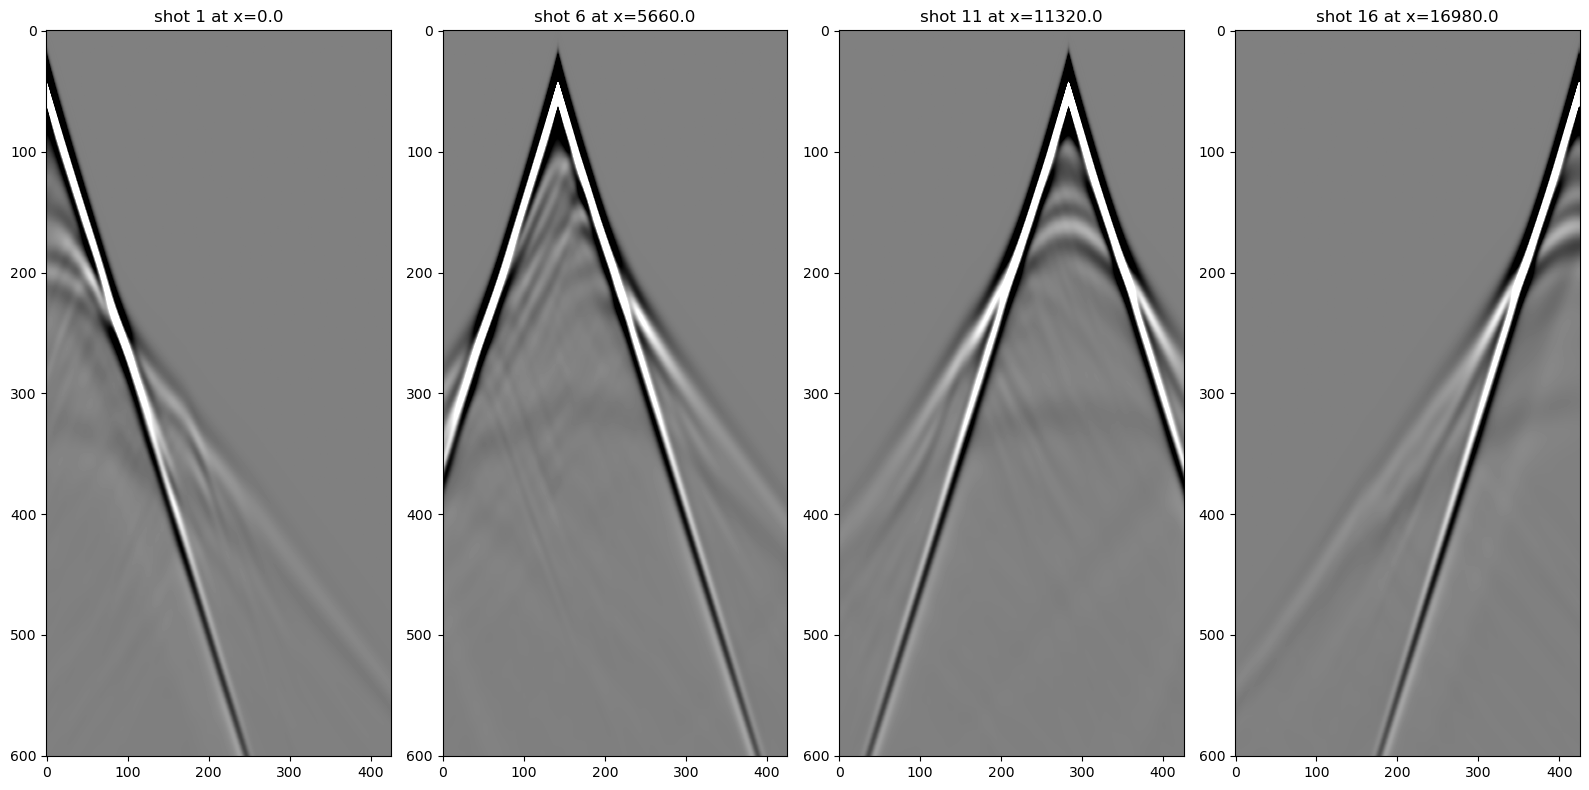

In [14]:
dmax = maximum(abs, extrema(d))
@show dmax
shots = [1:5:nshots;]
@show shots

figure(figsize=(16,8))
for (iplot,ishot) in enumerate(shots)
    subplot(1,4,iplot);
    imshow(getblock(d,ishot),cmap="gray",aspect="auto",clim=0.05.*[-dmax,+dmax]);
    title("shot $(ishot) at x=$(sx[ishot])");
end
tight_layout()

## 5. Build the gradient and cost functions

#### Build water bottom mask for gradient
We use this mask to remove imprint in gradient very close to the source locations. The mask is set to 0 wherever the true velocity model has value 1500 m/s, and is set to 1 otherwise. 

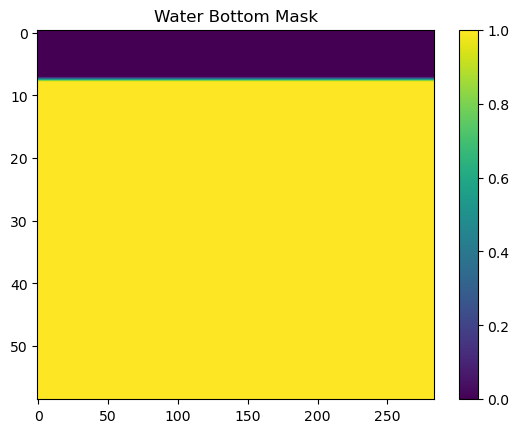

In [15]:
wb_mask = ones(Float32,size(v))
wb_mask[v.==1500.0].=0.0;
imshow(wb_mask,aspect="auto");colorbar(); title("Water Bottom Mask");

#### Gradient function
This method is called by the solver whenever the gradient is required. Steps in computing the gradient are as follows:
1. Compute the source side illumination
1. Establish the illumination compensation preconditioner as `1/illum^2`
1. Apply the adjoint of the Jacobian to the current residual `d - F*v` 
1. Apply very simple scaling based on the size of the first gradient

In [16]:
function gradient!(G,F,v,dobs,p,wb_mask)
    @show "J = jacobian(F,v)"
    J = jacobian(F,v)
    @show "s = srcillum(J)"
    s = srcillum(J)
    @show size(s)
    @show "s .= ((s ./ maximum(s)).^2) .+ 1e-8"
    s .= ((s ./ maximum(s)).^2) .+ 1e-8
    @show "R = JopDiagonal((1 ./ s).^2)"
    R = JopDiagonal((1 ./ s).^2)
    @show "G .= R' * J' * (dobs - F*v)"
    @show size(R')
    @show size(J')
    @show size(G)
    G .= R' ∘ J' * (dobs - F*v)
    @show "G .*= wb_mask"
    G .*= wb_mask #mute water column
    if p.gscale == 0.0
        @show "p.gscale = 10 ./ maximum(G)"
        p.gscale = 10 ./ maximum(G) #make a scalar from first gradient (then apply to all future gradients)
    end
    @show p.gscale
    @show "G .*= p.gscale"
    G .*= p.gscale
    close(F) #delete local files
    
    # Yo Miguel, why close(F) ??
end
mutable struct FwiPar
   gscale
end
p = FwiPar(0.0)
g!(G,x) = gradient!(G,F,x,d,p,wb_mask)

g! (generic function with 1 method)

#### Compute the initial gradient and display

In [17]:
grad = zeros(Float32,size(v))
g!(grad,vₒ)

"J = jacobian(F,v)" = "J = jacobian(F,v)"
"s = srcillum(J)" = "s = srcillum(J)"


[ Info: nonlinear forward on cbox-wask-HC44rs, srcfieldfile=/mnt/scratch/field-1-2MAAyloW.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  1801 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
[ Info: nonlinear forward on cbox-wask-HC44rs, srcfieldfile=/mnt/scratch/field-9-l1yzqFWb.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  1801 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1621 of  1801 ;   85.39 MCells/s (IO=18.86%, EX=33.28%) -- rms d,p; 0.0000e+00 5.8670e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1801 of  1801 ;   87.70 MCells/s (IO=19.09%, EX=33.82%) -- rms d,p; 0.0000e+00 4.1716e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1621 of  1801 ;   79.10 MCells/s (IO=15.90%, EX=45.91%) -- rms d,p; 0.0000e+00 6.9884e-01
[ Info: nonlinear forward on cbo

size(s) = (88, 426)
"s .= ((s ./ maximum(s)).^2) .+ 1e-8" = "s .= ((s ./ maximum(s)).^2) .+ 1e-8"
"R = JopDiagonal((1 ./ s).^2)" = "R = JopDiagonal((1 ./ s).^2)"
"G .= R' * J' * (dobs - F*v)" = "G .= R' * J' * (dobs - F*v)"
size(R') = (37488, 37488)
size(J') = (37488, 4096416)
size(G) = (59, 284)


[ Info: linear adjoint on cbox-wask-HC44rs, srcfieldfile=/mnt/scratch/field-9-l1yzqFWb.bin
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     1 of  1801 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%, IM= 0.00%) -- rms d,p; 2.0091e-01 0.0000e+00
[ Info: linear adjoint on cbox-wask-HC44rs, srcfieldfile=/mnt/scratch/field-1-2MAAyloW.bin
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     1 of  1801 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%, IM= 0.00%) -- rms d,p; 1.8966e-01 0.0000e+00
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step   181 of  1801 ;   31.11 MCells/s (IO= 0.59%, EX=29.67%, IM=11.63%) -- rms d,p; 2.0091e-01 2.9965e+01
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step   181 of  1801 ;   37.46 MCells/s (IO= 0.74%, EX=14.25%, IM=13.97%) -- rms d,p; 1.8966e-01 3.9951e+01
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step  1801 of  1801 ;   91.40 MCells/s (IO= 1.63%, EX=21.51%, IM=34.99%) -- rms d,p; 1.8966e-01 2.4415e+02
[ Info: linear adjoint 

LoadError: DimensionMismatch("array could not be broadcast to match destination")

In [ ]:
figure(figsize=(10,5))
imshow(grad,aspect="auto",cmap="seismic");colorbar();clim(-10,10);title("gradient");

In [ ]:
diffnorm(x, y) = sqrt(mapreduce(i->(x[i] - y[i])^2, +, 1:length(x)))
function cost(x,F,d)
    dm = F*x
    phi = diffnorm(d, dm)
    return phi
end
f(x) = cost(x,F,d)

In [ ]:
@info "initial cost $(f(vₒ))";

## 6. Do the FWI using optim.jl

In [ ]:
solver = LBFGS(m = 20, alphaguess = LineSearches.InitialQuadratic(), linesearch = LineSearches.MoreThuente());

In [ ]:
function mycallback(state::OptimizationState)
    @info "iter=$(state.iteration), cost=$(state.value), |grad|=$(state.g_norm)"
    false
end
mycallback(trace::OptimizationTrace) = mycallback(trace[end]);

In [ ]:
p = FwiPar(0.0)
redirect_stdout(open("/dev/null","w")) # otherwise the models are printed to stdout at every iteration
result = optimize(f, g!, vₒ, solver,
    Optim.Options(
        iterations = 100,
        show_trace = true,
        store_trace = true,
        show_every = 1,
        extended_trace = true,
        allow_f_increases = false,
        callback = mycallback))

In [ ]:
vfwi = Optim.minimizer(result) # optimal solution
ϕ = Optim.f_trace(result)   # cost vs iteration
m = Optim.x_trace(result);   # model vs iteration

In [ ]:
rmprocs(workers())

In [ ]:
figure(figsize=(20,5))
subplot(121);imshow(v,aspect="auto",cmap="jet");colorbar();clim(1500,4500);title("true velocity")
subplot(122);imshow(vfwi,aspect="auto",cmap="jet");colorbar();clim(1500,4500);title("fwi velocity");

In [ ]:
plot(ϕ)